In [14]:
!pip install -U mplsoccer

In [15]:
import json
import pandas as pd
import openpyxl
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from mplsoccer import Pitch, VerticalPitch, FontManager
from scipy.stats import gaussian_kde

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [16]:
def draw_pitch(ax):

    pitch_width = 80    
    pitch_length = 120  
    center_circle_radius = 9.15 
    penalty_area_length = 18  
    penalty_area_width = 44   
    goal_area_length = 6      
    goal_area_width = 20     


    ax.plot([0, 0], [0, pitch_length], color='black') 
    ax.plot([pitch_width, pitch_width], [0, pitch_length], color='black')  
    ax.plot([0, pitch_width], [0, 0], color='black')  
    ax.plot([0, pitch_width], [pitch_length, pitch_length], color='black')  

    ax.plot([0, pitch_width], [pitch_length / 2, pitch_length / 2], color='black')

    center_circle = plt.Circle((pitch_width / 2, pitch_length / 2), center_circle_radius, color='black', fill=False)
    ax.add_artist(center_circle)


    ax.plot([(pitch_width - penalty_area_width) / 2, (pitch_width - penalty_area_width) / 2],
            [0, penalty_area_length], color='black')
    ax.plot([(pitch_width + penalty_area_width) / 2, (pitch_width + penalty_area_width) / 2],
            [0, penalty_area_length], color='black')
    ax.plot([(pitch_width - penalty_area_width) / 2, (pitch_width + penalty_area_width) / 2],
            [penalty_area_length, penalty_area_length], color='black')

    ax.plot([(pitch_width - penalty_area_width) / 2, (pitch_width - penalty_area_width) / 2],
            [pitch_length - penalty_area_length, pitch_length], color='black')
    ax.plot([(pitch_width + penalty_area_width) / 2, (pitch_width + penalty_area_width) / 2],
            [pitch_length - penalty_area_length, pitch_length], color='black')
    ax.plot([(pitch_width - penalty_area_width) / 2, (pitch_width + penalty_area_width) / 2],
            [pitch_length - penalty_area_length, pitch_length - penalty_area_length], color='black')

    ax.plot([(pitch_width - goal_area_width) / 2, (pitch_width - goal_area_width) / 2],
            [0, goal_area_length], color='black')
    ax.plot([(pitch_width + goal_area_width) / 2, (pitch_width + goal_area_width) / 2],
            [0, goal_area_length], color='black')
    ax.plot([(pitch_width - goal_area_width) / 2, (pitch_width + goal_area_width) / 2],
            [goal_area_length, goal_area_length], color='black')

    ax.plot([(pitch_width - goal_area_width) / 2, (pitch_width - goal_area_width) / 2],
            [pitch_length - goal_area_length, pitch_length], color='black')
    ax.plot([(pitch_width + goal_area_width) / 2, (pitch_width + goal_area_width) / 2],
            [pitch_length - goal_area_length, pitch_length], color='black')
    ax.plot([(pitch_width - goal_area_width) / 2, (pitch_width + goal_area_width) / 2],
            [pitch_length - goal_area_length, pitch_length - goal_area_length], color='black')


    penalty_spot_distance = 12 


    ax.scatter(pitch_width / 2, penalty_spot_distance, color='black')


    ax.scatter(pitch_width / 2, pitch_length - penalty_spot_distance, color='black')

 
    ax.set_xlim(0, pitch_width)
    ax.set_ylim(0, pitch_length)
    ax.set_aspect('equal')
    ax.axis('off')


In [25]:
# D:/SoccerMatchData/data/events
folder_path = r"C:\Users\bouza\OneDrive\Desktop\data\events"
output_path = 'D:/SoccerMatchData/data/try'
goal = []
non_goal = []
json_files = glob.glob(f'{folder_path}/*.json')

for json_file in json_files:
    flag = True
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        # lineup_data = []
        if (data[0]['type']['name'] == 'Starting XI' and data[0]['team']['name'] == 'Barcelona') or data[1]['type']['name'] == 'Starting XI' and data[1]['team']['name'] == 'Barcelona':
            flag = False

        
    game_data = []
    i = 0
    if flag:
        continue    
    for match in data:
        if match['type']['name'] == "Shot" and match['team']['name'] == 'Barcelona':
            if 'freeze_frame' in match['shot']:
                fLocations = [frame['location'] for frame in match['shot']['freeze_frame']]
            else:
                fLocations = []
            game_data.append({
                'Time': match['timestamp'],
                'Team': match['team']['name'],
                'Player': match['player']['name'],
                'Location': match['location'],
                'Outcome': match['shot']['outcome']['name'],
                'Technique': match['shot']['technique']['name'],
                'Body_part': match['shot']['body_part']['name'],
                'xG': match['shot']['statsbomb_xg'],
                'fLocations': fLocations
            })

df = pd.DataFrame(game_data)
df_goals = (df[df['Outcome'] == 'Goal'])
df_non_goal = (df[df['Outcome'] != 'Goal'])
shot = []
goal_bool = np.array([])
goal = []
non_goal = []
xG_goal = []
xG_non_goal = []     
for index, row in df.iterrows():
    shot.append(row['Location'])
    if row['Outcome'] == 'Goal':
        goal_bool = np.append(goal_bool, 1)
    else:
        goal_bool = np.append(goal_bool, 0)
                
for index, row in df_goals.iterrows():
    location = row['Location']
    goal.append(location)
    xg = row['xG']
    xG_goal.append(xg)
    
for index, row in df_non_goal.iterrows():
        location = row['Location']
        non_goal.append(location)
        xg = row['xG']
        xG_non_goal.append(xg)
    
goal_coor = np.array(goal)
non_goal_coor = np.array(non_goal)
xG_g = np.array(xG_goal)
xG_non_g = np.array(xG_non_goal)
shoot = np.array(shot)

# np.save(output_path+'/goal_coor.npy', goal_coor)
# np.save(output_path+'/non_goal_coor.npy', non_goal_coor)
# np.save(output_path+'/xG_g.npy', xG_g)
# np.save(output_path+'/xG_non_g.npy', xG_non_g) 
# np.save(output_path+'/goal_bool.npy', goal_bool) 
# np.save(output_path+'/shot_location.npy', shoot)      
# pitch = VerticalPitch(pad_bottom=0.5,  
#                       half=True,  
#                       goal_type='box',
#                       goal_alpha=0.8, pitch_color='#22312b', line_color='#c7d5cc')  # control the goal transparency

# fig, ax = pitch.draw(figsize=(12, 10))

# ax.scatter(goal_coor[:, 1], goal_coor[:, 0], c='#ad993c', s = 5, label='Goal')

# ax.scatter(non_goal_coor[:, 1], non_goal_coor[:, 0], c='#ba4f45', s = 5, label='No goal')

# ax.legend()
# plt.show()
print(df)


            Time       Team                          Player       Location  \
0   00:09:37.349  Barcelona            Andrés Iniesta Luján   [98.5, 25.5]   
1   00:11:29.077  Barcelona                Jordi Alba Ramos  [106.9, 26.1]   
2   00:16:48.437  Barcelona        Luis Alberto Suárez Díaz   [96.8, 25.7]   
3   00:17:47.753  Barcelona           Gerard Piqué Bernabéu  [108.5, 39.4]   
4   00:24:46.176  Barcelona                    Ivan Rakitić  [109.4, 39.7]   
5   00:26:37.104  Barcelona        Luis Alberto Suárez Díaz  [108.2, 48.9]   
6   00:11:21.786  Barcelona       Philippe Coutinho Correia   [97.3, 26.4]   
7   00:19:45.762  Barcelona                    Ivan Rakitić  [101.5, 56.7]   
8   00:22:18.319  Barcelona           Gerard Piqué Bernabéu  [109.4, 42.4]   
9   00:23:28.518  Barcelona          Denis Suárez Fernández  [109.3, 50.4]   
10  00:31:17.003  Barcelona  Lionel Andrés Messi Cuccittini  [110.2, 36.3]   
11  00:39:52.201  Barcelona        Francisco Alcácer García  [10

In [19]:
def extract_data(output_path):
    return np.load(output_path)

In [ ]:
# import numpy as np
left_post_team1_2d = np.array([0, 36]) 
right_post_team1_2d =  np.array([0, 44])  
left_post_team2_2d = np.array([120, 44]) 
right_post_team2_2d = np.array([120, 36])
  
# def perceivedLength(shot_location):
#     global left_post_team1, right_post_team2, left_post_team2, right_post_team1
#     first_dist = np.linalg.norm(shot_location - left_post_team1)
#     second_dist = np.linalg.norm(shot_location - right_post_team2)
#     # print("First distance is " + str(first_dist))
#     # print("Second distance is " + str(second_dist))
#     if first_dist < second_dist: 
#         left_post = left_post_team1
#         right_post = right_post_team1
#     else:  
#         left_post = left_post_team2
#         right_post = right_post_team2

#     post_to_post_dist = np.linalg.norm(left_post - right_post) 
#     shot_to_left_post = np.linalg.norm(shot_location - left_post)  
#     shot_to_right_post = np.linalg.norm(shot_location - right_post) 

#     cos_theta = (shot_to_left_post**2 + shot_to_right_post**2 - post_to_post_dist**2) / (2 * shot_to_left_post * shot_to_right_post)
#     angle_rad = np.arccos(cos_theta)  
    
#     angle_deg = np.degrees(angle_rad)
#     return angle_deg

# df['angle'] = df['Location'].apply(lambda loc: perceivedLength(np.array(loc)))
# print(df)
# test = np.array([20,43.7])
def is_point_in_triangle(point, a, b, c):
    def triangle_area(aa, bb, cc):
        return abs((aa[0] * (bb[1] - cc[1]) + bb[0] * (cc[1] - aa[1]) + cc[0] * (aa[1] - bb[1])) / 2.0)
    
    area_abc = triangle_area(a, b, c)
    area_abp = triangle_area(a, b, point)
    area_bcp = triangle_area(b, c, point)
    area_cap = triangle_area(c, a, point)

    return area_abc == area_abp + area_bcp + area_cap
def trianglePlayers(df):
    shot_location = np.array(df['Location'])  
    freeze_frame = df['fLocations']
    print(f"Processing shot at location: {shot_location}, with freeze_frame: {freeze_frame}")
    if shot_location[1] < 60:  
        left_post = left_post_team1_2d
        right_post = right_post_team1_2d
    else:
        left_post = left_post_team2_2d
        right_post = right_post_team2_2d
    players_in_window = []
    for frame in freeze_frame:
        player_location = np.array(frame)
        
        if is_point_in_triangle(player_location, shot_location, left_post, right_post):
            distance_to_shot = np.linalg.norm(player_location - shot_location)
            players_in_window.append(distance_to_shot) 
    
    # Find closest player if any are in the window
    if players_in_window:
        return min(players_in_window) 
    else:
        return np.nan 

df['Closest_Player_Distance'] = df.apply(trianglePlayers, axis=1)
print(df)


Processing shot at location: [98.5 25.5], with freeze_frame: [[103.3, 21.4], [101.4, 23.2], [102.2, 29.0], [104.8, 33.4], [99.7, 28.1], [92.5, 36.8], [98.5, 18.2], [103.3, 46.0], [117.7, 37.6], [103.8, 14.5], [100.7, 51.7], [101.5, 31.0]]
Processing shot at location: [106.9  26.1], with freeze_frame: [[108.8, 50.8], [112.5, 24.8], [105.9, 36.7], [97.1, 55.1], [100.5, 41.7], [98.4, 35.1], [112.0, 49.1], [113.1, 43.7], [112.4, 40.9], [114.7, 33.2], [103.3, 53.1], [111.4, 31.4], [103.3, 42.9], [104.9, 33.7], [117.4, 37.3]]
Processing shot at location: [96.8 25.7], with freeze_frame: [[105.4, 27.4], [105.3, 28.3], [104.8, 29.8], [105.0, 29.0], [107.0, 32.0], [106.5, 30.2], [106.2, 31.2], [99.0, 34.8], [101.5, 35.7], [105.5, 30.3], [118.5, 41.5], [107.1, 43.0], [106.6, 41.9], [103.5, 47.8], [97.4, 45.6], [107.5, 45.6], [105.8, 39.9], [103.6, 40.5]]
Processing shot at location: [108.5  39.4], with freeze_frame: [[112.1, 37.4], [111.1, 34.5], [107.8, 36.7], [118.4, 42.3], [111.9, 44.9], [113.

In [20]:
left_post_team1 = np.array([0, 36, 0]) 
right_post_team1 =  np.array([0, 44, 0])
mid_ground_team1 = np.array([0, 40, 0])
mid_top_team1 = np.array([0, 40, 2.67])
left_post_team2 = np.array([120, 44, 0]) 
right_post_team2 = np.array([120, 36, 0])
mid_ground_team2 = np.array([120, 40, 0])
mid_top_team2 = np.array([120, 40, 2.67])

def perceivedLength3d(shot_location):
    global left_post_team1, right_post_team2, left_post_team2, right_post_team1, mid_top_team1, mid_top_team2, mid_ground_team1, mid_ground_team2
    first_dist = np.linalg.norm(shot_location - left_post_team1)
    second_dist = np.linalg.norm(shot_location - right_post_team2)
    # print("First distance is " + str(first_dist))
    # print("Second distance is " + str(second_dist))
    if first_dist < second_dist: 
        left_post = left_post_team1
        right_post = right_post_team1
        mid_top = mid_top_team1
        mid_ground = mid_ground_team1
    else:  
        left_post = left_post_team2
        right_post = right_post_team2
        mid_top = mid_top_team2
        mid_ground = mid_ground_team2

    #2d 
    post_to_post_dist = np.linalg.norm(left_post - right_post) 
    shot_to_left_post = np.linalg.norm(shot_location - left_post)  
    shot_to_right_post = np.linalg.norm(shot_location - right_post) 

    top_to_shot = np.linalg.norm(shot_location - mid_top) 
    ground_mid_to_shot = np.linalg.norm(shot_location - mid_ground) 
    top_to_mid = np.linalg.norm(mid_top - mid_ground) 

    cos_theta_1d = (shot_to_left_post**2 + shot_to_right_post**2 - post_to_post_dist**2) / (2 * shot_to_left_post * shot_to_right_post)
    cos_theta_2d = cos_theta_2d = (top_to_shot**2 + ground_mid_to_shot**2 - top_to_mid**2) / (2 * top_to_shot * ground_mid_to_shot)

    angle_rad = np.arccos(cos_theta_1d)  
    angle_rad_2 = np.arccos(cos_theta_2d)

    angle_deg = np.degrees(angle_rad)
    angle_deg_2 = np.degrees(angle_rad_2)
    pLength = angle_deg * angle_deg_2
    return pLength

test = np.array([35,43.7, 0])

df['Location'] = df['Location'].apply(lambda loc: np.append(loc, [0]))

df['pl3D'] = df['Location'].apply(lambda loc: perceivedLength3d(np.array(loc)))
print(df)



            Time       Team                          Player  \
0   00:09:37.349  Barcelona            Andrés Iniesta Luján   
1   00:11:29.077  Barcelona                Jordi Alba Ramos   
2   00:16:48.437  Barcelona        Luis Alberto Suárez Díaz   
3   00:17:47.753  Barcelona           Gerard Piqué Bernabéu   
4   00:24:46.176  Barcelona                    Ivan Rakitić   
5   00:26:37.104  Barcelona        Luis Alberto Suárez Díaz   
6   00:11:21.786  Barcelona       Philippe Coutinho Correia   
7   00:19:45.762  Barcelona                    Ivan Rakitić   
8   00:22:18.319  Barcelona           Gerard Piqué Bernabéu   
9   00:23:28.518  Barcelona          Denis Suárez Fernández   
10  00:31:17.003  Barcelona  Lionel Andrés Messi Cuccittini   
11  00:39:52.201  Barcelona        Francisco Alcácer García   

              Location  Outcome    Technique   Body_part        xG        pl3D  
0    [98.5, 25.5, 0.0]    Off T       Normal  Right Foot  0.028284   86.302490  
1   [106.9, 26.1, 

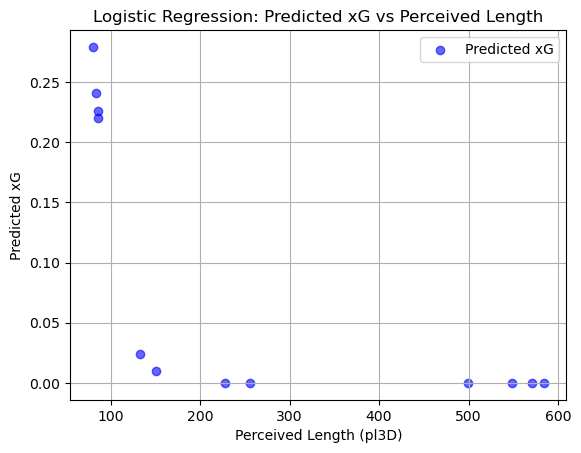

In [24]:
def logistic_regression(df, pLength_col, goal_col):
    X = np.array(df[pLength_col]).reshape(-1, 1)
    y = df[goal_col]
    
    model = LogisticRegression()
    model.fit(X, y)

    y_pred = model.predict_proba(X)[:, 1]

    models = {
        'model': model,
        'y_pred': y_pred
    }
    df['predicted_xG'] = y_pred

    return models
    
def plot_logistic_regression(df, pLength_col, models):
    plt.scatter(df[pLength_col], models['y_pred'], label='Predicted xG', color='blue', alpha=0.6)
    plt.xlabel('Perceived Length (pl3D)')
    plt.ylabel('Predicted xG')
    plt.title('Logistic Regression: Predicted xG vs Perceived Length')
    plt.grid(True)
    plt.legend()
    plt.show()

df['Goal'] = df['Outcome'].apply(lambda outcome: 1 if outcome == 'Goal' else 0)
models = logistic_regression(df, pLength_col='pl3D', goal_col='Goal')
plot_logistic_regression(df, pLength_col='pl3D', models=models)